<a href="https://colab.research.google.com/github/SenolIsci/TimeSeries/blob/main/Time_related_feature_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip3 install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.7 MB 38.7 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [5]:
!python3 -m pip show scikit-learn

Name: scikit-learn
Version: 1.2.0
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: None
Author-email: None
License: new BSD
Location: /usr/local/lib/python3.8/dist-packages
Requires: threadpoolctl, scipy, joblib, numpy
Required-by: yellowbrick, sklearn-pandas, qudida, mlxtend, lightgbm, librosa, imbalanced-learn, fastai


In [ ]:
%matplotlib inline


# Time-related feature engineering

This notebook introduces different strategies to leverage time-related features
for a bike sharing demand regression task that is highly dependent on business
cycles (days, weeks, months) and yearly season cycles.

In the process, we introduce how to perform periodic feature engineering using
the :class:`sklearn.preprocessing.SplineTransformer` class and its
`extrapolation="periodic"` option.


## Data exploration on the Bike Sharing Demand dataset

We start by loading the data from the OpenML repository.



In [6]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml(
    "Bike_Sharing_Demand", version=2, as_frame=True, parser="pandas"
)
df = bike_sharing.frame

To get a quick understanding of the periodic patterns of the data, let us
have a look at the average demand per hour during a week.

Note that the week starts on a Sunday, during the weekend. We can clearly
distinguish the commute patterns in the morning and evenings of the work days
and the leisure use of the bikes on the weekends with a more spread peak
demand around the middle of the days:



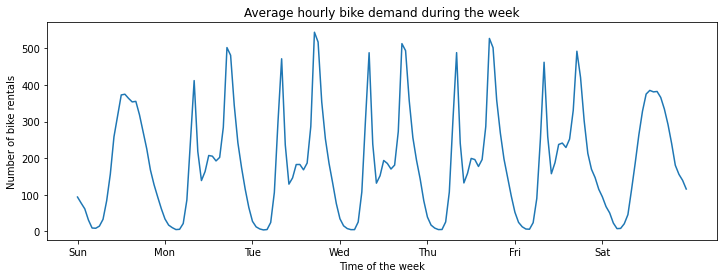

In [7]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(12, 4))
average_week_demand = df.groupby(["weekday", "hour"])["count"].mean()
average_week_demand.plot(ax=ax)
_ = ax.set(
    title="Average hourly bike demand during the week",
    xticks=[i * 24 for i in range(7)],
    xticklabels=["Sun", "Mon", "Tue", "Wed", "Thu", "Fri", "Sat"],
    xlabel="Time of the week",
    ylabel="Number of bike rentals",
)

The target of the prediction problem is the absolute count of bike rentals on
a hourly basis:



In [8]:
df["count"].max()

977

Let us rescale the target variable (number of hourly bike rentals) to predict
a relative demand so that the mean absolute error is more easily interpreted
as a fraction of the maximum demand.

<div class="alert alert-info"><h4>Note</h4><p>The fit method of the models used in this notebook all minimize the
    mean squared error to estimate the conditional mean instead of the mean
    absolute error that would fit an estimator of the conditional median.

    When reporting performance measure on the test set in the discussion, we
    instead choose to focus on the mean absolute error that is more
    intuitive than the (root) mean squared error. Note, however, that the
    best models for one metric are also the best for the other in this
    study.</p></div>



In [9]:
y = df["count"] / df["count"].max()

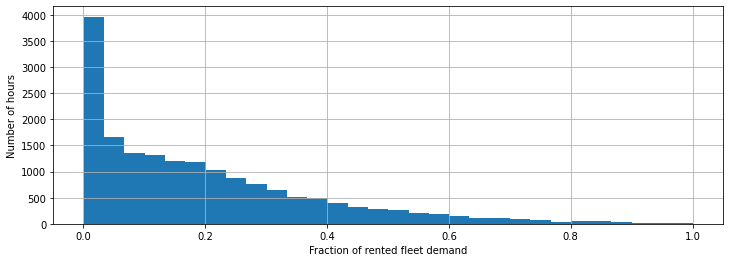

In [10]:
fig, ax = plt.subplots(figsize=(12, 4))
y.hist(bins=30, ax=ax)
_ = ax.set(
    xlabel="Fraction of rented fleet demand",
    ylabel="Number of hours",
)

The input feature data frame is a time annotated hourly log of variables
describing the weather conditions. It includes both numerical and categorical
variables. Note that the time information has already been expanded into
several complementary columns.




In [11]:
X = df.drop("count", axis="columns")
X

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0000
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0000
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0000
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0000
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981


<div class="alert alert-info"><h4>Note</h4><p>If the time information was only present as a date or datetime column, we
   could have expanded it into hour-in-the-day, day-in-the-week,
   day-in-the-month, month-in-the-year using pandas:
   https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components</p></div>

We now introspect the distribution of the categorical variables, starting
with `"weather"`:




In [12]:
X["weather"].value_counts()

clear         11413
misty          4544
rain           1419
heavy_rain        3
Name: weather, dtype: int64

Since there are only 3 `"heavy_rain"` events, we cannot use this category to
train machine learning models with cross validation. Instead, we simplify the
representation by collapsing those into the `"rain"` category.




In [13]:
X["weather"].replace(to_replace="heavy_rain", value="rain", inplace=True)

In [14]:
X["weather"].value_counts()

clear    11413
misty     4544
rain      1422
Name: weather, dtype: int64

As expected, the `"season"` variable is well balanced:




In [15]:
X["season"].value_counts()

fall      4496
summer    4409
spring    4242
winter    4232
Name: season, dtype: int64

## Time-based cross-validation

Since the dataset is a time-ordered event log (hourly demand), we will use a
time-sensitive cross-validation splitter to evaluate our demand forecasting
model as realistically as possible. We use a gap of 2 days between the train
and test side of the splits. We also limit the training set size to make the
performance of the CV folds more stable.

1000 test datapoints should be enough to quantify the performance of the
model. This represents a bit less than a month and a half of contiguous test
data:



In [16]:
from sklearn.model_selection import TimeSeriesSplit

ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=48,
    max_train_size=10000,
    test_size=1000,
)

Let us manually inspect the various splits to check that the
`TimeSeriesSplit` works as we expect, starting with the first split:



In [17]:
all_splits = list(ts_cv.split(X, y))
train_0, test_0 = all_splits[0]

In [18]:
X.iloc[test_0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
12379,summer,1,6,0,False,2,True,clear,22.14,25.760,0.68,27.9993
12380,summer,1,6,1,False,2,True,misty,21.32,25.000,0.77,22.0028
12381,summer,1,6,2,False,2,True,rain,21.32,25.000,0.72,19.9995
12382,summer,1,6,3,False,2,True,rain,20.50,24.240,0.82,12.9980
12383,summer,1,6,4,False,2,True,rain,20.50,24.240,0.82,12.9980
...,...,...,...,...,...,...,...,...,...,...,...,...
13374,fall,1,7,11,False,1,True,clear,34.44,40.150,0.53,15.0013
13375,fall,1,7,12,False,1,True,clear,34.44,39.395,0.49,8.9981
13376,fall,1,7,13,False,1,True,clear,34.44,39.395,0.49,19.0012
13377,fall,1,7,14,False,1,True,clear,36.08,40.910,0.42,7.0015


In [19]:
X.iloc[train_0]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
2331,summer,0,4,1,False,2,True,misty,25.42,31.060,0.50,6.0032
2332,summer,0,4,2,False,2,True,misty,24.60,31.060,0.53,8.9981
2333,summer,0,4,3,False,2,True,misty,23.78,27.275,0.56,8.9981
2334,summer,0,4,4,False,2,True,misty,22.96,26.515,0.64,8.9981
2335,summer,0,4,5,False,2,True,misty,22.14,25.760,0.68,8.9981
...,...,...,...,...,...,...,...,...,...,...,...,...
12326,summer,1,6,19,False,6,False,clear,26.24,31.060,0.36,11.0014
12327,summer,1,6,20,False,6,False,clear,25.42,31.060,0.35,19.0012
12328,summer,1,6,21,False,6,False,clear,24.60,31.060,0.40,7.0015
12329,summer,1,6,22,False,6,False,clear,23.78,27.275,0.46,8.9981


We now inspect the last split:



In [20]:
train_4, test_4 = all_splits[4]

In [21]:
X.iloc[test_4]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
16379,winter,1,11,5,False,2,True,misty,13.94,16.665,0.66,8.9981
16380,winter,1,11,6,False,2,True,misty,13.94,16.665,0.71,11.0014
16381,winter,1,11,7,False,2,True,clear,13.12,16.665,0.76,6.0032
16382,winter,1,11,8,False,2,True,clear,13.94,16.665,0.71,8.9981
16383,winter,1,11,9,False,2,True,misty,14.76,18.940,0.71,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,spring,1,12,19,False,1,True,misty,10.66,12.880,0.60,11.0014
17375,spring,1,12,20,False,1,True,misty,10.66,12.880,0.60,11.0014
17376,spring,1,12,21,False,1,True,clear,10.66,12.880,0.60,11.0014
17377,spring,1,12,22,False,1,True,clear,10.66,13.635,0.56,8.9981


In [22]:
X.iloc[train_4]

,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed
6331,winter,0,9,9,False,1,True,misty,26.24,28.790,0.89,12.9980
6332,winter,0,9,10,False,1,True,misty,26.24,28.790,0.89,12.9980
6333,winter,0,9,11,False,1,True,clear,27.88,31.820,0.79,15.0013
6334,winter,0,9,12,False,1,True,misty,27.88,31.820,0.79,11.0014
6335,winter,0,9,13,False,1,True,misty,28.70,33.335,0.74,11.0014
...,...,...,...,...,...,...,...,...,...,...,...,...
16326,winter,1,11,0,False,0,False,misty,12.30,15.150,0.70,11.0014
16327,winter,1,11,1,False,0,False,clear,12.30,14.395,0.70,12.9980
16328,winter,1,11,2,False,0,False,clear,11.48,14.395,0.81,7.0015
16329,winter,1,11,3,False,0,False,misty,12.30,15.150,0.81,11.0014


All is well. We are now ready to do some predictive modeling!

## Gradient Boosting

Gradient Boosting Regression with decision trees is often flexible enough to
efficiently handle heteorogenous tabular data with a mix of categorical and
numerical features as long as the number of samples is large enough.

Here, we do minimal ordinal encoding for the categorical variables and then
let the model know that it should treat those as categorical variables by
using a dedicated tree splitting rule. Since we use an ordinal encoder, we
pass the list of categorical values explicitly to use a logical order when
encoding the categories as integers instead of the lexicographical order.
This also has the added benefit of preventing any issue with unknown
categories when using cross-validation.

The numerical variables need no preprocessing and, for the sake of simplicity,
we only try the default hyper-parameters for this model:



In [23]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate


categorical_columns = [
    "weather",
    "season",
    "holiday",
    "workingday",
]
categories = [
    ["clear", "misty", "rain"],
    ["spring", "summer", "fall", "winter"],
    ["False", "True"],
    ["False", "True"],
]
ordinal_encoder = OrdinalEncoder(categories=categories)


gbrt_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", ordinal_encoder, categorical_columns),
        ],
        remainder="passthrough",
        # Use short feature names to make it easier to specify the categorical
        # variables in the HistGradientBoostingRegressor in the next
        # step of the pipeline.
        verbose_feature_names_out=False,
    ),
    HistGradientBoostingRegressor(
        categorical_features=categorical_columns,
    ),
).set_output(transform="pandas")

Lets evaluate our gradient boosting model with the mean absolute error of the
relative demand averaged across our 5 time-based cross-validation splits:



In [24]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )


evaluate(gbrt_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.044 +/- 0.003
Root Mean Squared Error: 0.068 +/- 0.005


This model has an average error around 4 to 5% of the maximum demand. This is
quite good for a first trial without any hyper-parameter tuning! We just had
to make the categorical variables explicit. Note that the time related
features are passed as is, i.e. without processing them. But this is not much
of a problem for tree-based models as they can learn a non-monotonic
relationship between ordinal input features and the target.

This is not the case for linear regression models as we will see in the
following.

## Naive linear regression

As usual for linear models, categorical variables need to be one-hot encoded.
For consistency, we scale the numerical features to the same 0-1 range using
class:`sklearn.preprocessing.MinMaxScaler`, although in this case it does not
impact the results much because they are already on comparable scales:



In [25]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
import numpy as np


one_hot_encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
alphas = np.logspace(-6, 6, 25)
naive_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)


evaluate(naive_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.142 +/- 0.014
Root Mean Squared Error: 0.184 +/- 0.020


The performance is not good: the average error is around 14% of the maximum
demand. This is more than three times higher than the average error of the
gradient boosting model. We can suspect that the naive original encoding
(merely min-max scaled) of the periodic time-related features might prevent
the linear regression model to properly leverage the time information: linear
regression does not automatically model non-monotonic relationships between
the input features and the target. Non-linear terms have to be engineered in
the input.

For example, the raw numerical encoding of the `"hour"` feature prevents the
linear model from recognizing that an increase of hour in the morning from 6
to 8 should have a strong positive impact on the number of bike rentals while
an increase of similar magnitude in the evening from 18 to 20 should have a
strong negative impact on the predicted number of bike rentals.

## Time-steps as categories

Since the time features are encoded in a discrete manner using integers (24
unique values in the "hours" feature), we could decide to treat those as
categorical variables using a one-hot encoding and thereby ignore any
assumption implied by the ordering of the hour values.

Using one-hot encoding for the time features gives the linear model a lot
more flexibility as we introduce one additional feature per discrete time
level.



In [26]:
one_hot_linear_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder=MinMaxScaler(),
    ),
    RidgeCV(alphas=alphas),
)

evaluate(one_hot_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.099 +/- 0.011
Root Mean Squared Error: 0.131 +/- 0.011


The average error rate of this model is 10% which is much better than using
the original (ordinal) encoding of the time feature, confirming our intuition
that the linear regression model benefits from the added flexibility to not
treat time progression in a monotonic manner.

However, this introduces a very large number of new features. If the time of
the day was represented in minutes since the start of the day instead of
hours, one-hot encoding would have introduced 1440 features instead of 24.
This could cause some significant overfitting. To avoid this we could use
:func:`sklearn.preprocessing.KBinsDiscretizer` instead to re-bin the number
of levels of fine-grained ordinal or numerical variables while still
benefitting from the non-monotonic expressivity advantages of one-hot
encoding.

Finally, we also observe that one-hot encoding completely ignores the
ordering of the hour levels while this could be an interesting inductive bias
to preserve to some level. In the following we try to explore smooth,
non-monotonic encoding that locally preserves the relative ordering of time
features.

## Trigonometric features

As a first attempt, we can try to encode each of those periodic features
using a sine and cosine transformation with the matching period.

Each ordinal time feature is transformed into 2 features that together encode
equivalent information in a non-monotonic way, and more importantly without
any jump between the first and the last value of the periodic range.



In [27]:
from sklearn.preprocessing import FunctionTransformer


def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

Let us visualize the effect of this feature expansion on some synthetic hour
data with a bit of extrapolation beyond hour=23:



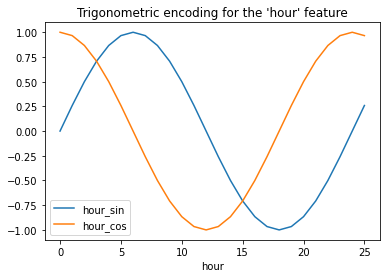

In [28]:
import pandas as pd

hour_df = pd.DataFrame(
    np.arange(26).reshape(-1, 1),
    columns=["hour"],
)
hour_df["hour_sin"] = sin_transformer(24).fit_transform(hour_df)["hour"]
hour_df["hour_cos"] = cos_transformer(24).fit_transform(hour_df)["hour"]
hour_df.plot(x="hour")
_ = plt.title("Trigonometric encoding for the 'hour' feature")

Let's use a 2D scatter plot with the hours encoded as colors to better see
how this representation maps the 24 hours of the day to a 2D space, akin to
some sort of a 24 hour version of an analog clock. Note that the "25th" hour
is mapped back to the 1st hour because of the periodic nature of the
sine/cosine representation.



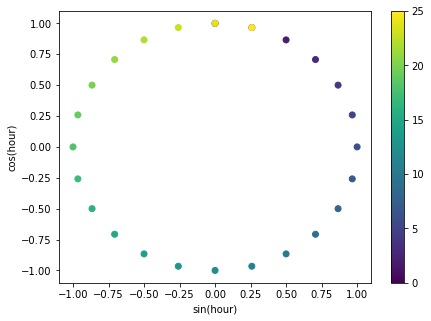

In [29]:
fig, ax = plt.subplots(figsize=(7, 5))
sp = ax.scatter(hour_df["hour_sin"], hour_df["hour_cos"], c=hour_df["hour"])
ax.set(
    xlabel="sin(hour)",
    ylabel="cos(hour)",
)
_ = fig.colorbar(sp)

We can now build a feature extraction pipeline using this strategy:



In [30]:
cyclic_cossin_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("month_sin", sin_transformer(12), ["month"]),
        ("month_cos", cos_transformer(12), ["month"]),
        ("weekday_sin", sin_transformer(7), ["weekday"]),
        ("weekday_cos", cos_transformer(7), ["weekday"]),
        ("hour_sin", sin_transformer(24), ["hour"]),
        ("hour_cos", cos_transformer(24), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_cossin_linear_pipeline = make_pipeline(
    cyclic_cossin_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_cossin_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.125 +/- 0.014
Root Mean Squared Error: 0.166 +/- 0.020


The performance of our linear regression model with this simple feature
engineering is a bit better than using the original ordinal time features but
worse than using the one-hot encoded time features. We will further analyze
possible reasons for this disappointing outcome at the end of this notebook.

## Periodic spline features

We can try an alternative encoding of the periodic time-related features
using spline transformations with a large enough number of splines, and as a
result a larger number of expanded features compared to the sine/cosine
transformation:



In [31]:
from sklearn.preprocessing import SplineTransformer


def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )

Again, let us visualize the effect of this feature expansion on some
synthetic hour data with a bit of extrapolation beyond hour=23:



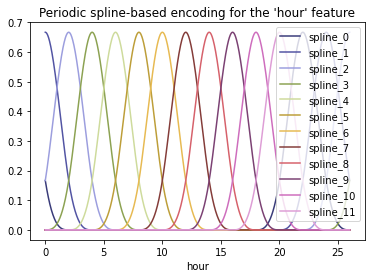

In [32]:
hour_df = pd.DataFrame(
    np.linspace(0, 26, 1000).reshape(-1, 1),
    columns=["hour"],
)
splines = periodic_spline_transformer(24, n_splines=12).fit_transform(hour_df)
splines_df = pd.DataFrame(
    splines,
    columns=[f"spline_{i}" for i in range(splines.shape[1])],
)
pd.concat([hour_df, splines_df], axis="columns").plot(x="hour", cmap=plt.cm.tab20b)
_ = plt.title("Periodic spline-based encoding for the 'hour' feature")

Thanks to the use of the `extrapolation="periodic"` parameter, we observe
that the feature encoding stays smooth when extrapolating beyond midnight.

We can now build a predictive pipeline using this alternative periodic
feature engineering strategy.

It is possible to use fewer splines than discrete levels for those ordinal
values. This makes spline-based encoding more efficient than one-hot encoding
while preserving most of the expressivity:



In [33]:
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("categorical", one_hot_encoder, categorical_columns),
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["weekday"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)
cyclic_spline_linear_pipeline = make_pipeline(
    cyclic_spline_transformer,
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_linear_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.097 +/- 0.011
Root Mean Squared Error: 0.132 +/- 0.013


Spline features make it possible for the linear model to successfully
leverage the periodic time-related features and reduce the error from ~14% to
~10% of the maximum demand, which is similar to what we observed with the
one-hot encoded features.

## Qualitative analysis of the impact of features on linear model predictions

Here, we want to visualize the impact of the feature engineering choices on
the time related shape of the predictions.

To do so we consider an arbitrary time-based split to compare the predictions
on a range of held out data points.



In [34]:
naive_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
naive_linear_predictions = naive_linear_pipeline.predict(X.iloc[test_0])

one_hot_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_linear_predictions = one_hot_linear_pipeline.predict(X.iloc[test_0])

cyclic_cossin_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_cossin_linear_predictions = cyclic_cossin_linear_pipeline.predict(X.iloc[test_0])

cyclic_spline_linear_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_linear_predictions = cyclic_spline_linear_pipeline.predict(X.iloc[test_0])

We visualize those predictions by zooming on the last 96 hours (4 days) of
the test set to get some qualitative insights:



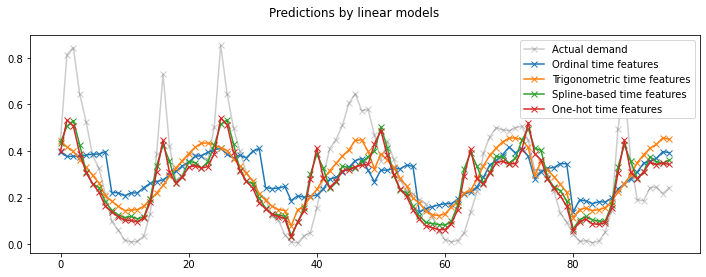

In [35]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by linear models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(naive_linear_predictions[last_hours], "x-", label="Ordinal time features")
ax.plot(
    cyclic_cossin_linear_predictions[last_hours],
    "x-",
    label="Trigonometric time features",
)
ax.plot(
    cyclic_spline_linear_predictions[last_hours],
    "x-",
    label="Spline-based time features",
)
ax.plot(
    one_hot_linear_predictions[last_hours],
    "x-",
    label="One-hot time features",
)
_ = ax.legend()

We can draw the following conclusions from the above plot:

- The **raw ordinal time-related features** are problematic because they do
  not capture the natural periodicity: we observe a big jump in the
  predictions at the end of each day when the hour features goes from 23 back
  to 0. We can expect similar artifacts at the end of each week or each year.

- As expected, the **trigonometric features** (sine and cosine) do not have
  these discontinuities at midnight, but the linear regression model fails to
  leverage those features to properly model intra-day variations.
  Using trigonometric features for higher harmonics or additional
  trigonometric features for the natural period with different phases could
  potentially fix this problem.

- the **periodic spline-based features** fix those two problems at once: they
  give more expressivity to the linear model by making it possible to focus
  on specific hours thanks to the use of 12 splines. Furthermore the
  `extrapolation="periodic"` option enforces a smooth representation between
  `hour=23` and `hour=0`.

- The **one-hot encoded features** behave similarly to the periodic
  spline-based features but are more spiky: for instance they can better
  model the morning peak during the week days since this peak lasts shorter
  than an hour. However, we will see in the following that what can be an
  advantage for linear models is not necessarily one for more expressive
  models.



We can also compare the number of features extracted by each feature
engineering pipeline:



In [36]:
naive_linear_pipeline[:-1].transform(X).shape

(17379, 19)

In [37]:
one_hot_linear_pipeline[:-1].transform(X).shape

(17379, 59)

In [38]:
cyclic_cossin_linear_pipeline[:-1].transform(X).shape

(17379, 22)

In [39]:
cyclic_spline_linear_pipeline[:-1].transform(X).shape

(17379, 37)

This confirms that the one-hot encoding and the spline encoding strategies
create a lot more features for the time representation than the alternatives,
which in turn gives the downstream linear model more flexibility (degrees of
freedom) to avoid underfitting.

Finally, we observe that none of the linear models can approximate the true
bike rentals demand, especially for the peaks that can be very sharp at rush
hours during the working days but much flatter during the week-ends: the most
accurate linear models based on splines or one-hot encoding tend to forecast
peaks of commuting-related bike rentals even on the week-ends and
under-estimate the commuting-related events during the working days.

These systematic prediction errors reveal a form of under-fitting and can be
explained by the lack of interactions terms between features, e.g.
"workingday" and features derived from "hours". This issue will be addressed
in the following section.



## Modeling pairwise interactions with splines and polynomial features

Linear models do not automatically capture interaction effects between input
features. It does not help that some features are marginally non-linear as is
the case with features constructed by `SplineTransformer` (or one-hot
encoding or binning).

However, it is possible to use the `PolynomialFeatures` class on coarse
grained spline encoded hours to model the "workingday"/"hours" interaction
explicitly without introducing too many new variables:



In [40]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion


hour_workday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("workingday", FunctionTransformer(lambda x: x == "True"), ["workingday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

Those features are then combined with the ones already computed in the
previous spline-base pipeline. We can observe a nice performance improvemnt
by modeling this pairwise interaction explicitly:



In [41]:
cyclic_spline_interactions_pipeline = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions", hour_workday_interaction),
        ]
    ),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_interactions_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.078 +/- 0.009
Root Mean Squared Error: 0.104 +/- 0.009


## Modeling non-linear feature interactions with kernels

The previous analysis highlighted the need to model the interactions between
`"workingday"` and `"hours"`. Another example of a such a non-linear
interaction that we would like to model could be the impact of the rain that
might not be the same during the working days and the week-ends and holidays
for instance.

To model all such interactions, we could either use a polynomial expansion on
all marginal features at once, after their spline-based expansion. However,
this would create a quadratic number of features which can cause overfitting
and computational tractability issues.

Alternatively, we can use the Nyström method to compute an approximate
polynomial kernel expansion. Let us try the latter:



In [42]:
from sklearn.kernel_approximation import Nystroem


cyclic_spline_poly_pipeline = make_pipeline(
    cyclic_spline_transformer,
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(cyclic_spline_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.053 +/- 0.002
Root Mean Squared Error: 0.076 +/- 0.004


We observe that this model can almost rival the performance of the gradient
boosted trees with an average error around 5% of the maximum demand.

Note that while the final step of this pipeline is a linear regression model,
the intermediate steps such as the spline feature extraction and the Nyström
kernel approximation are highly non-linear. As a result the compound pipeline
is much more expressive than a simple linear regression model with raw features.

For the sake of completeness, we also evaluate the combination of one-hot
encoding and kernel approximation:



In [43]:
one_hot_poly_pipeline = make_pipeline(
    ColumnTransformer(
        transformers=[
            ("categorical", one_hot_encoder, categorical_columns),
            ("one_hot_time", one_hot_encoder, ["hour", "weekday", "month"]),
        ],
        remainder="passthrough",
    ),
    Nystroem(kernel="poly", degree=2, n_components=300, random_state=0),
    RidgeCV(alphas=alphas),
)
evaluate(one_hot_poly_pipeline, X, y, cv=ts_cv)

Mean Absolute Error:     0.082 +/- 0.006
Root Mean Squared Error: 0.111 +/- 0.011


While one-hot encoded features were competitive with spline-based features
when using linear models, this is no longer the case when using a low-rank
approximation of a non-linear kernel: this can be explained by the fact that
spline features are smoother and allow the kernel approximation to find a
more expressive decision function.

Let us now have a qualitative look at the predictions of the kernel models
and of the gradient boosted trees that should be able to better model
non-linear interactions between features:



In [44]:
gbrt_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
gbrt_predictions = gbrt_pipeline.predict(X.iloc[test_0])

one_hot_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
one_hot_poly_predictions = one_hot_poly_pipeline.predict(X.iloc[test_0])

cyclic_spline_poly_pipeline.fit(X.iloc[train_0], y.iloc[train_0])
cyclic_spline_poly_predictions = cyclic_spline_poly_pipeline.predict(X.iloc[test_0])

Again we zoom on the last 4 days of the test set:



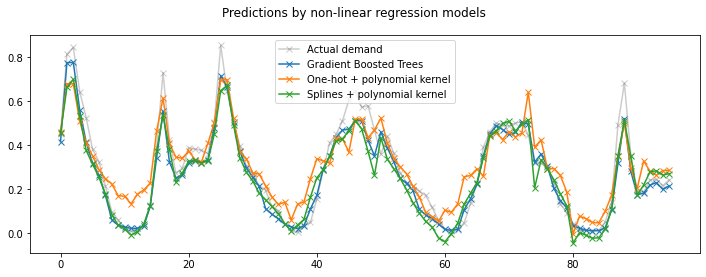

In [45]:
last_hours = slice(-96, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Predictions by non-linear regression models")
ax.plot(
    y.iloc[test_0].values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual demand",
    color="black",
)
ax.plot(
    gbrt_predictions[last_hours],
    "x-",
    label="Gradient Boosted Trees",
)
ax.plot(
    one_hot_poly_predictions[last_hours],
    "x-",
    label="One-hot + polynomial kernel",
)
ax.plot(
    cyclic_spline_poly_predictions[last_hours],
    "x-",
    label="Splines + polynomial kernel",
)
_ = ax.legend()

First, note that trees can naturally model non-linear feature interactions
since, by default, decision trees are allowed to grow beyond a depth of 2
levels.

Here, we can observe that the combinations of spline features and non-linear
kernels works quite well and can almost rival the accuracy of the gradient
boosting regression trees.

On the contrary, one-hot encoded time features do not perform that well with
the low rank kernel model. In particular, they significantly over-estimate
the low demand hours more than the competing models.

We also observe that none of the models can successfully predict some of the
peak rentals at the rush hours during the working days. It is possible that
access to additional features would be required to further improve the
accuracy of the predictions. For instance, it could be useful to have access
to the geographical repartition of the fleet at any point in time or the
fraction of bikes that are immobilized because they need servicing.

Let us finally get a more quantative look at the prediction errors of those
three models using the true vs predicted demand scatter plots:



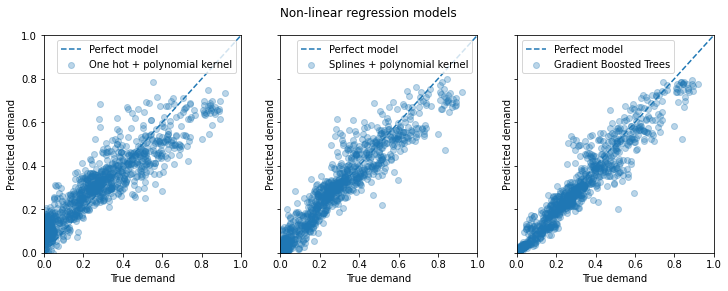

In [46]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle("Non-linear regression models")
predictions = [
    one_hot_poly_predictions,
    cyclic_spline_poly_predictions,
    gbrt_predictions,
]
labels = [
    "One hot + polynomial kernel",
    "Splines + polynomial kernel",
    "Gradient Boosted Trees",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y.iloc[test_0].values, pred, alpha=0.3, label=label)
    ax.plot([0, 1], [0, 1], "--", label="Perfect model")
    ax.set(
        xlim=(0, 1),
        ylim=(0, 1),
        xlabel="True demand",
        ylabel="Predicted demand",
    )
    ax.legend()

plt.show()

This visualization confirms the conclusions we draw on the previous plot.

All models under-estimate the high demand events (working day rush hours),
but gradient boosting a bit less so. The low demand events are well predicted
on average by gradient boosting while the one-hot polynomial regression
pipeline seems to systematically over-estimate demand in that regime. Overall
the predictions of the gradient boosted trees are closer to the diagonal than
for the kernel models.

## Concluding remarks

We note that we could have obtained slightly better results for kernel models
by using more components (higher rank kernel approximation) at the cost of
longer fit and prediction durations. For large values of `n_components`, the
performance of the one-hot encoded features would even match the spline
features.

The `Nystroem` + `RidgeCV` regressor could also have been replaced by
:class:`~sklearn.neural_network.MLPRegressor` with one or two hidden layers
and we would have obtained quite similar results.

The dataset we used in this case study is sampled on a hourly basis. However
cyclic spline-based features could model time-within-day or time-within-week
very efficiently with finer-grained time resolutions (for instance with
measurements taken every minute instead of every hours) without introducing
more features. One-hot encoding time representations would not offer this
flexibility.

Finally, in this notebook we used `RidgeCV` because it is very efficient from
a computational point of view. However, it models the target variable as a
Gaussian random variable with constant variance. For positive regression
problems, it is likely that using a Poisson or Gamma distribution would make
more sense. This could be achieved by using
`GridSearchCV(TweedieRegressor(power=2), param_grid({"alpha": alphas}))`
instead of `RidgeCV`.

